## 02427 Advanced Time Series Analysis
### Computer exercise 1

Niklas Christoffer Petersen, [niklch@dtu.dk](niklch@dtu.dk) 

October 10, 2018

In [ ]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.arima_model 
from statsmodels.tsa.stattools import acf, pacf

from IPython.display import Markdown as md
import matplotlib.pyplot as plt

%matplotlib inline

### Part 1
We define number of simulations, and time steps

In [2]:
N = 1000
ts = np.arange(N)

#### SETAR

We define a $\text{SETAR}(2, 1, 1)$ model, i.e. two regimes, delay 1 and auto-regressive order 1 (in both regimes):
$$
y_t =
\left\{
    \begin{array}{ll}
        0.2 + y_{t - 1} + \epsilon_t & \text{if} \; y_{t - 1} < 100 \\
        10 + 0.95 y_{t - 1} + \epsilon_t & \text{if} \; y_{t - 1} \geq 100
    \end{array}
\right.
$$

This could be some systam that has a threashhold around 100 at which the process will increase faster than before (times 8).

In [3]:
def setar(N):
    r = np.random.randn(N)
    y = np.empty(N)
    y[0] = r[0]
    for t in range(1, N):
        if y[t-1] < 100:
            y[t] = .2 + y[t-1] + r[t]
        else:
            y[t] = 10 + 0.95*y[t-1] + r[t]
    return y, r

In [4]:
# Ensure reproducability
np.random.seed(seed=42)
# Run N simulations
y_setar, r_setar = setar(N)

Save the results for later:

In [5]:
np.save('setar_2_1_1.npy', np.stack([r_setar, y_setar], axis = 1))

We plot the time series. The model parameters define a ragime change when $y_{t - 1}$ gets above 100, triggering from a slowly increasing state to a more rapid increasing state, that stabilizes quickly around 200.

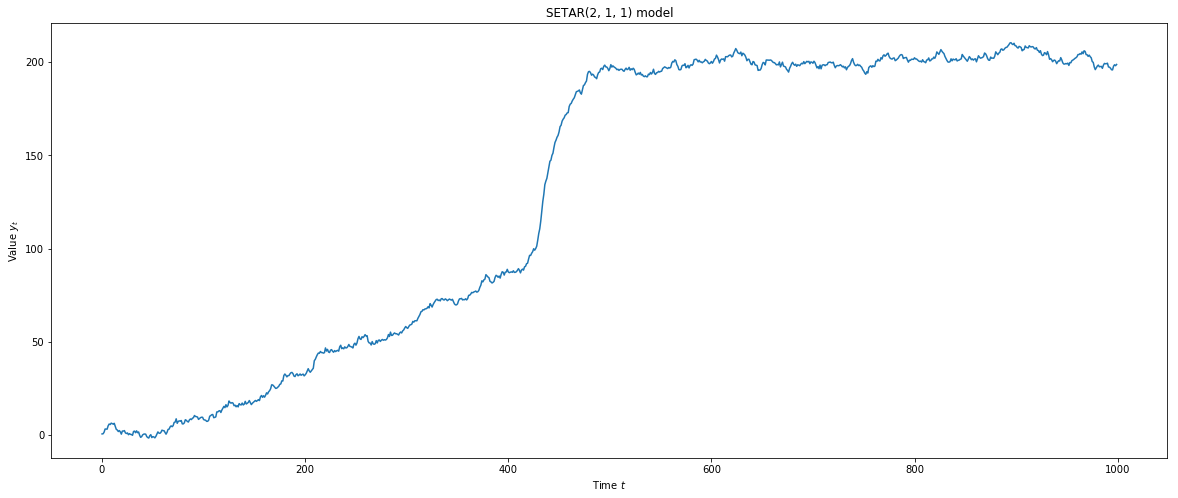

In [6]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.set_title('SETAR(2, 1, 1) model')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'Value $y_t$')
ax.plot(ts, y_setar, marker = '', linestyle = '-')
None

#### IGAR
Next we try with a $\text{IGAR}(2, 1)$ model:
$$
\left\{
    \begin{array}{ll}
        0.2 + y_{t - 1} & \text{with} \; p = 99\% \\
        -8 + 0.8 y_{t - 1} & \text{with} \; p = 1\%
    \end{array}
\right.
$$

This could be simulation of earnings of stocks. That is, in general there is a good chance (99%) that you will earn a little bit (0.2) every day. But on some more rare occasions the stock will drop, costing your 20% of your earnings plus a fixed loss (8).

In [7]:
def igar(N):
    r = np.random.randn(N)
    y = np.empty(N)
    y[0] = r[0]
    j = np.random.rand(N)
    for t in range(1, N):        
        if j[t] < .99:
            y[t] = .2 + y[t-1] + r[t]
        else:
            y[t] = -8 + 0.8 * y[t-1] + r[t]
    return y, r

In [8]:
# Ensure reproducability
np.random.seed(seed=42)
# Run N simulations
y_igar, r_igar = igar(N)

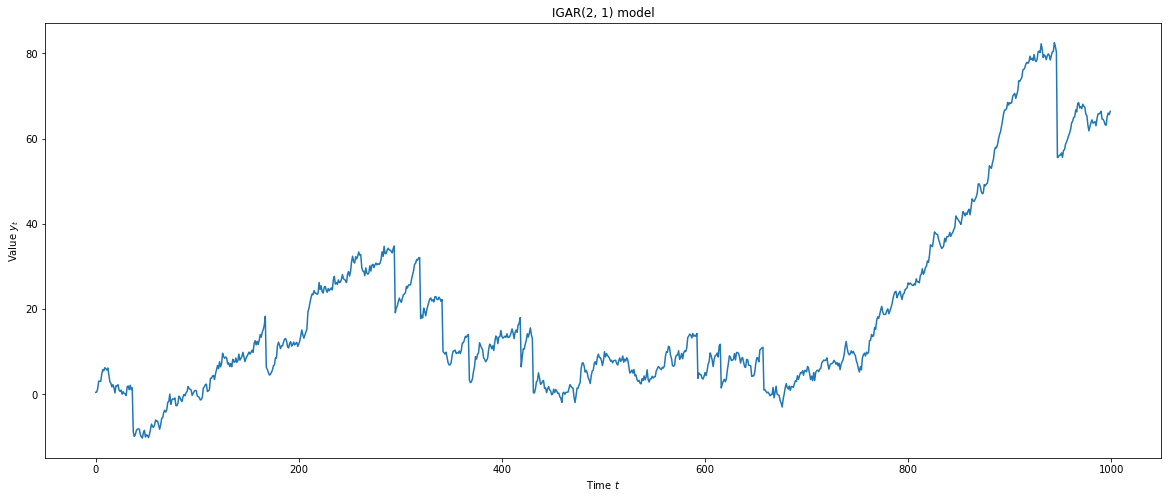

In [9]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.set_title('IGAR(2, 1) model')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'Value $y_t$')
ax.plot(ts, y_igar, marker = '', linestyle = '-')
None

#### MMAR

We try a MMAR(2, 1) model with the transition probabilities given as:
$$
P = \left[
    \begin{array}{rr}
        0.99 & 0.01 \\
        0.10 & 0.90 \\
    \end{array}
    \right]
$$

In [10]:
P = np.array([
    [.99, .01],
    [.1, .9]
])

Again, this could be simulation of earnings of stocks, but now when a loosing regime is entered ($\textit{State 1}$), there is a higher probability that one will stay in the loosing regime for a while before returning to the earnings regime ($\textit{State 0}$).

In [11]:
def mmar(N,P):    
    r = np.random.randn(N)
    y = np.empty(N)
    y[0] = r[0]    
    state = np.zeros(N).astype(int)
    for t in range(1, N): 
        p_trans = P[state[t - 1]]
        state[t] = np.random.choice(len(P), p = p_trans)
        if state[t] == 0:
            y[t] = .2 + y[t-1] + r[t]
        else:
            y[t] = -8 + 0.8 * y[t-1] + r[t]
    return y, r, state

In [12]:
# Ensure reproducability
np.random.seed(seed=42)
# Run N simulations
y_mmar, r_mmar, s_mmar = mmar(N,P)

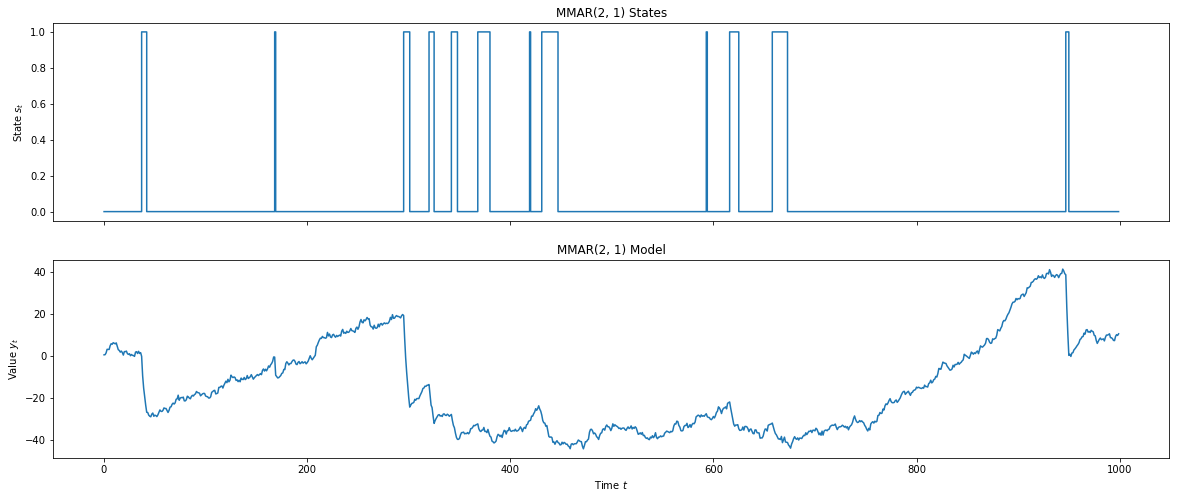

In [13]:
fig, ax = plt.subplots(2, 1, figsize = (20, 8), sharex = True)
ax[0].set_title('MMAR(2, 1) States')
ax[0].set_ylabel(r'State $s_t$')
ax[0].step(ts, s_mmar, marker = '', linestyle = '-')

ax[1].set_title('MMAR(2, 1) Model')
ax[1].set_xlabel(r'Time $t$')
ax[1].set_ylabel(r'Value $y_t$')
ax[1].plot(ts, y_mmar, marker = '', linestyle = '-')
None

### Part 2

We compute the theoretical conditional mean, $M(x) = E\left\{X_{t+1} \; | \; X_t = x\right\}$, for the $\text{SETAR}(2,1,1)$ model provided above.

$$
M(x) =
\left\{
    \begin{array}{ll}
        0.2 + x & \text{if} \; x < 100 \\
        10 + 0.95 x & \text{if} \; x \geq 100
    \end{array}
\right.
$$

We simulate 1000 values from the chosen SETAR model. First we plot the expected value $E[X_{t+11}\;|\; X_t = x]$ as a function of the condition $X_t = x$:

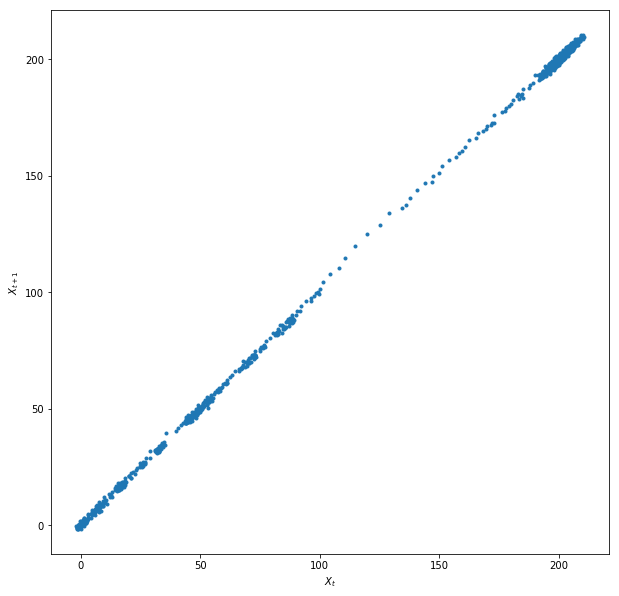

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(y_setar[:-1], y_setar[1:], linestyle = '', marker = '.')
ax.set_xlabel(r'$X_t$')
ax.set_ylabel(r'$X_{t + 1}$')
None

Then, we use the simulated data and a local regression model to estimate the $\hat{M}(x) = E\left\{X_{t+1} \; | \; X_t = x\right\}$:

In [15]:
bws = np.arange(.1, .6, .1)
md("We use the folloing bandwidths: " + ', '.join(['**%.1f**' % bw for bw in bws]))

We use the folloing bandwidths: **0.1**, **0.2**, **0.3**, **0.4**, **0.5**

We calculate local linear estimates given the different bandwidths:

In [16]:
lowess = [sm.nonparametric.lowess(y_setar[:-1], y_setar[1:], frac = bw, it = 0) for bw in bws]

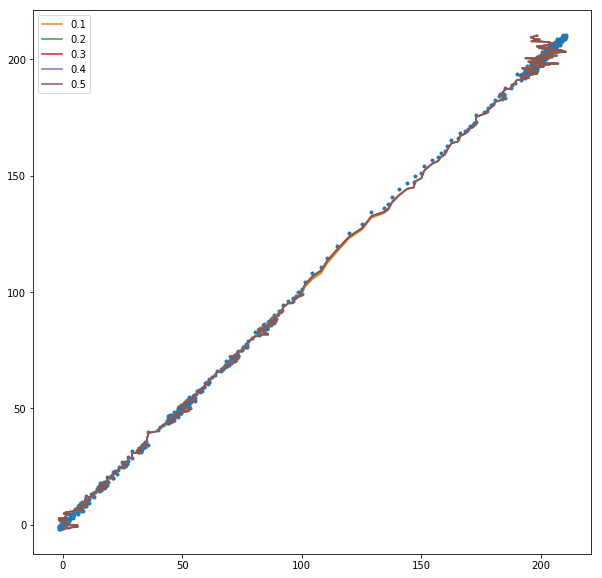

In [17]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(y_setar[:-1], y_setar[1:], marker = '.', linestyle = '')
for i in range(len(bws)):
    ax.plot(y_setar[:-1], lowess[i][:, 1], marker = '', linestyle = '-', label = str(bws[i]))
ax.legend()
None

Wee see that the 0.5 bandwoth seems to be too averaging in the ends, but otherwise they all seem to capture the relationship with the lag 1 input.

We also try to apply the LOESS method directly on the time series data:

In [18]:
lowess_ts = [sm.nonparametric.lowess(y_setar, ts, frac = bw, it = 0) for bw in bws]

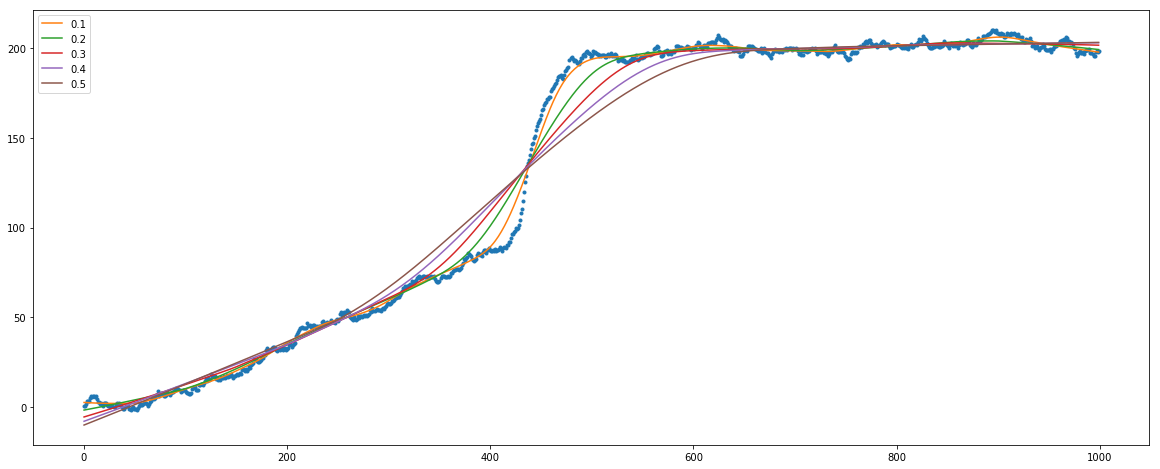

In [19]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(ts, y_setar, marker = '.', linestyle = '')
for i in range(len(bws)):
    ax.plot(ts, lowess_ts[i][:, 1], marker = '', linestyle = '-', label = str(bws[i]))
ax.legend()
None

We see that the 0.1 bandwith most closely captures the regime shift, and does not seem to be too affected by local noise.

### Part 3

Parameters for the histogram regression

In [20]:
## Number of intervals 
n_bins = 10
## The breaks between the intervals 
breaks = np.linspace(min(y_setar), max(y_setar), n_bins + 1)

In [21]:
## Initialize
h = np.diff(breaks)[0]
l = np.zeros(n_bins)
g = np.zeros(n_bins)
f_hat = np.zeros(n_bins)
h_hat = np.zeros(n_bins)

In [22]:
## Calc the hist regressogram, i.e. for each interval
for i in range(n_bins):
    x_bin = y_setar[(breaks[i] <= y_setar) & (y_setar < breaks[i+1])]
    assert(len(x_bin) > 5)
    l[i] = x_bin.mean()
    g[i] = np.sum((x_bin - l[i])**2) / len(x_bin)
    f_hat[i] = (n_bins*h)**(-1) * len(x_bin)    
    h_hat[i] = g[i]/f_hat[i];

In [23]:
L = (l*h).cumsum()
H_hat = (h_hat*h).cumsum();

In [24]:
## Make confidence bands for the cumulated function. Def. (3.10).
## 95% confidence band, c is found in table 3.1
c_alpha = 1.273

In [25]:
H_hat_b = H_hat[-1];
L_low = L - c_alpha * n_bins**(-0.5) * H_hat_b**(0.5) * (1 + H_hat/H_hat_b);
L_upr = L + c_alpha * n_bins**(-0.5) * H_hat_b**(0.5) * (1 + H_hat/H_hat_b);

We plot the computed cumulative means with confidence intervals:

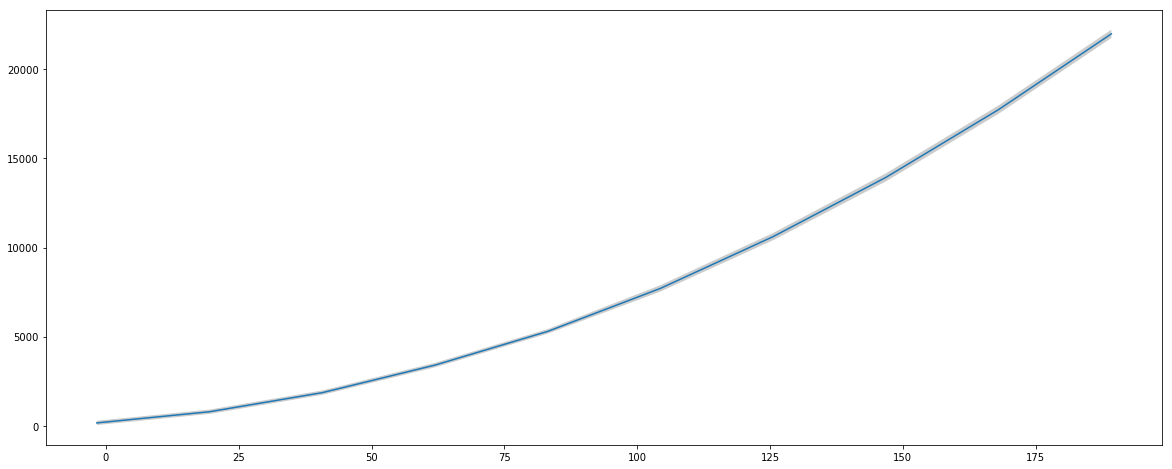

In [26]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.fill_between(breaks[0:-1], L_low, L_upr,  facecolor='#cccccc')
ax.plot(breaks[0:-1], L, marker = '', linestyle = '-')
None

We compare with the theoretical cumulative conditional mean and explore the assymptotic behaviour:

$$
M(x) =
\left\{
    \begin{array}{ll}
        0.2 + x & \text{if} \; x < 100 \\
        10 + 0.95 x & \text{if} \; x \geq 100
    \end{array}
\right.
$$

We compute the theoritical cimmilative conditinal mean piecewise:

For the first piece we have:
$$\int 0.2+x \; \text{d}x = 0.2x + \frac{1}{2} x^2 + C$$

And for the second piece we have:
$$\int  10 + 0.95 x \; \text{d}x = 10x + \frac{1}{2} 0.95 x^2 + C$$

In [27]:
piece_1 = lambda x: .2*x + .5 * x**2
piece_2 = lambda x: 10*x + .5 * 0.95 * x**2

We sum over the pieces:

In [28]:
np.sum([
    piece_1(100) - piece_1(min(y_setar)),
    piece_2(max(y_setar)) - piece_2(100) 
])

22410.585718956514

We see, that the theoritical commulative mean is very similar compared to the computed using the histogram approach:

In [29]:
L[-1]

21990.377257477867

The small difference is considered to be a result of the histogram approach, altough it is not even within the confidence interval:

In [30]:
print(L_low[-1], '-', L_upr[-1])

21755.7060825 - 22225.0484325


For now we are not invesigrating this further, since the theoretical and computed com.sum. means are still very close.


### Part 4

We load the data:

In [31]:
data_heat = pd.read_csv('DataPart4.csv')
data_heat.head(5)

,Ph,Ti,Te,W
0,1496.970334,20.002530,12.255610,8.678768
1,1411.792178,19.957051,12.298405,7.185271
2,1368.595696,19.904727,12.576470,6.684292
3,1404.547674,19.886161,12.455047,7.702868
4,1376.436161,19.908530,12.638600,7.047383


Lets take a quick look at data. Visible strong correlation between $W$ and $T_e$, But also pattern in $T_i$ which seem to raise at night (?). We see a clear cyclic pattern.

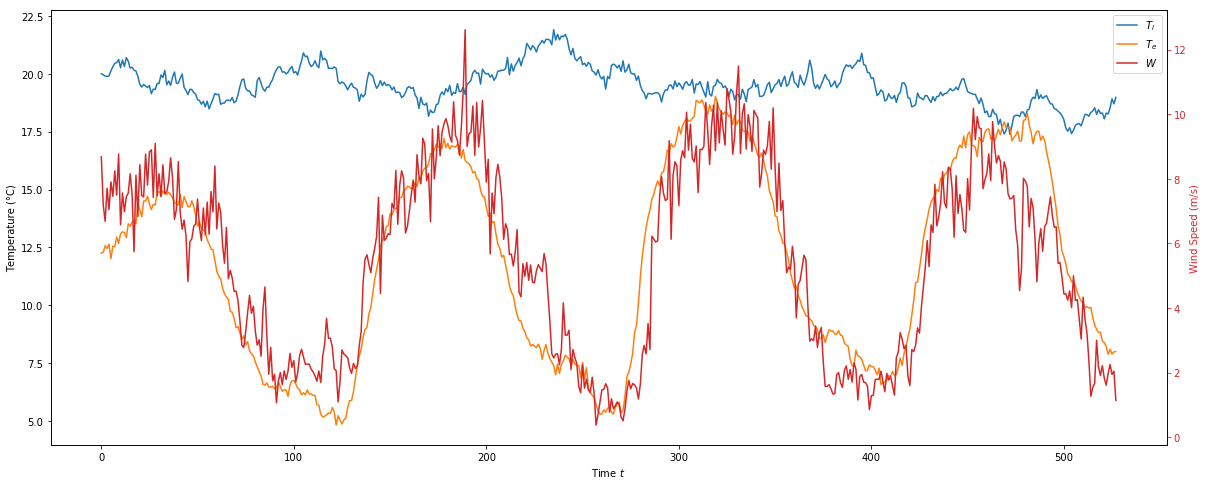

In [32]:
fig, ax = plt.subplots(figsize = (20, 8))
lns1 = ax.plot(data_heat['Ti'], label = r'$T_i$')
lns2 = ax.plot(data_heat['Te'], label = r'$T_e$')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel('Temperature (°C)')
ax_sec = ax.twinx()
lns3 = ax_sec.plot(data_heat['W'], label = r'$W$', color = 'C3')
ax_sec.set_ylabel('Wind Speed (m/s)', color='C3')
ax_sec.tick_params('y', colors='C3')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
None

We calculate and plot $U_a(W_t)$ and plot is both side by side with $W_t$ as a function of $t$ and as a function of $W_t$.

In [33]:
W = data_heat['W']
U_W = data_heat['Ph'] / (data_heat['Ti'] - data_heat['Te'])

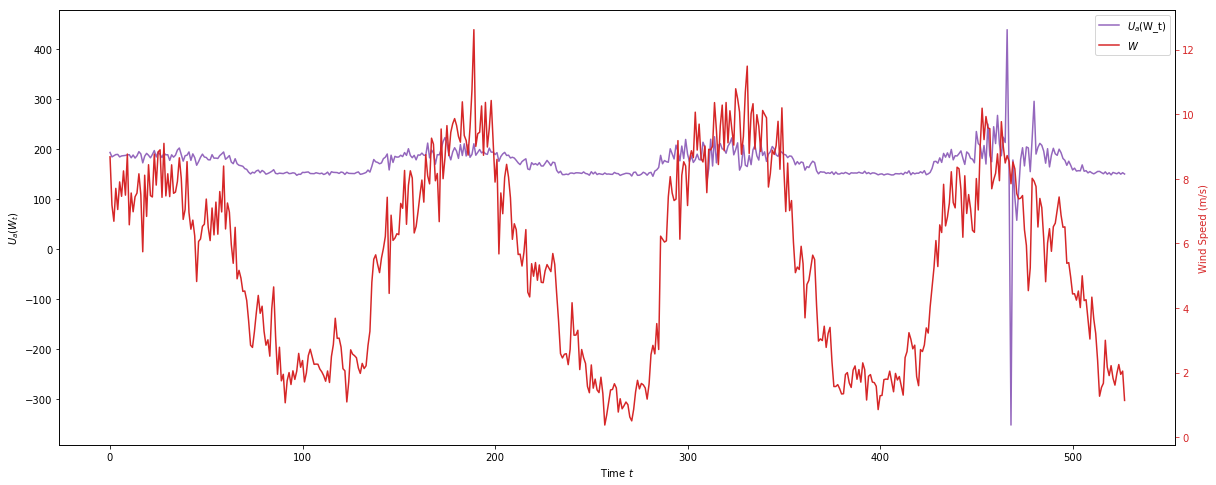

In [34]:
fig, ax = plt.subplots(figsize = (20, 8))
lns1 = ax.plot(U_W, label = r'$U_a($W_t$)$', color = 'C4')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'$U_a(W_t)$')
ax_sec = ax.twinx()
lns2 = ax_sec.plot(data_heat['W'], label = r'$W$', color = 'C3')
ax_sec.set_ylabel('Wind Speed (m/s)', color='C3')
ax_sec.tick_params('y', colors='C3')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
None

Wee still see the cyclic pattern, but now we see that $U_a(W_t)$ seems to have a lower limit around ~150 (unit?). We also see that the function has extreem values when $T_i < T_e$.

We fit LOEES model for $U_a(W_t) \sim W_t$ - this time implemented directly using linear regressen steps (using numpy's polyfit).

In [35]:
# Epanechnikov kernel
def ep_kernel(xall, x, h):
  ## Make the weights with an Epanechnikov kernel
  ## h has the same unit as x (i.e. it is on the same absolute scale, so if x is Watt, h is also given in Watt) 
  u = np.abs(xall - x)
  u = u / h
  w = 3/4 * (1 - u**2)
  ## Set values with |u|>1 to 0
  w[np.abs(u) > 1] = 0
  return w

In [36]:
hs = bws*(W.max() - W.min())
fit = np.empty([len(hs), len(W)])
fit[:,:] = np.nan
for i in range(len(W)):
    for j in range(len(hs)):
        w = ep_kernel(W, W[i], hs[j])
        coefs = poly.polyfit(x = W, y = U_W, deg = 1, w = w)
        fit[j, i] = poly.polyval(W[i], coefs)    

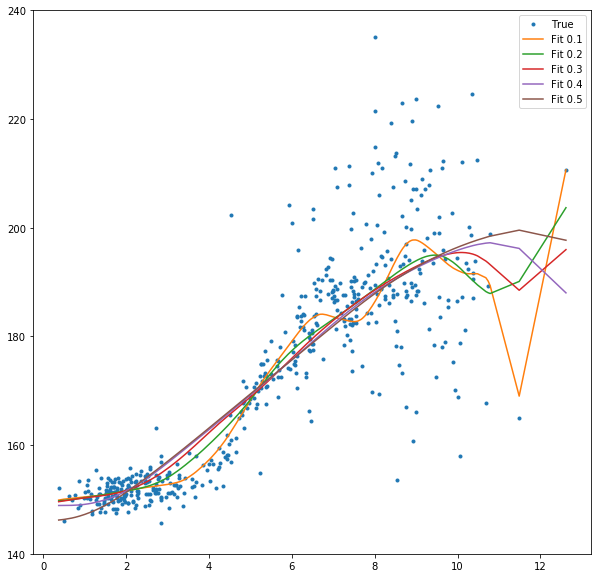

In [37]:
df = pd.DataFrame({'W': W, 'U_W': U_W})
for i in range(len(bws)):
    df['Fit %.1f' % bws[i]] = fit[i, :]
    
df = df.sort_values('W').reset_index(drop = True)

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df['W'], df['U_W'], linestyle = '', marker = '.', label = 'True')
for i in range(len(bws)):
    ax.plot(df['W'], df['Fit %.1f' % bws[i]], linestyle = '-', marker = '', label = 'Fit %.1f' % bws[i])
ax.set_ylim(140, 240)
ax.legend()
None

Just for comparison we estimate model using stat-models *lowess*-function. We get similar results, and difference it assumably because this uses a different kernel, and also some implementation/algorithm differences.

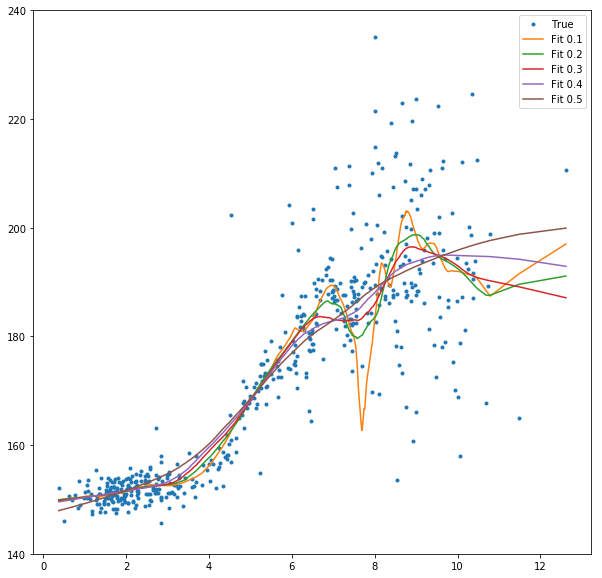

In [38]:
U_W_lowess = [sm.nonparametric.lowess(U_W, W, frac = bw, it = 0) for bw in bws]

df2 = pd.DataFrame({'W': W, 'U_W': U_W}).sort_values('W').reset_index(drop = True)

for i in range(len(bws)):
    df2['Fit %.1f' % bws[i]] = U_W_lowess[i][:,1]

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df2['W'], df2['U_W'], linestyle = '', marker = '.', label = 'True')
for i in range(len(bws)):
    ax.plot(df2['W'], df2['Fit %.1f' % bws[i]], linestyle = '-', marker = '', label = 'Fit %.1f' % bws[i])
ax.set_ylim(140, 240)
ax.legend()
None

### Part 5

We load the data:

In [39]:
data = pd.read_csv('DataPart5.csv')
data.head(5)

,x
0,0.000000
1,0.000000
2,0.043702
3,0.244185
4,0.228373


We take a quick look at the data (first 200 obs.)

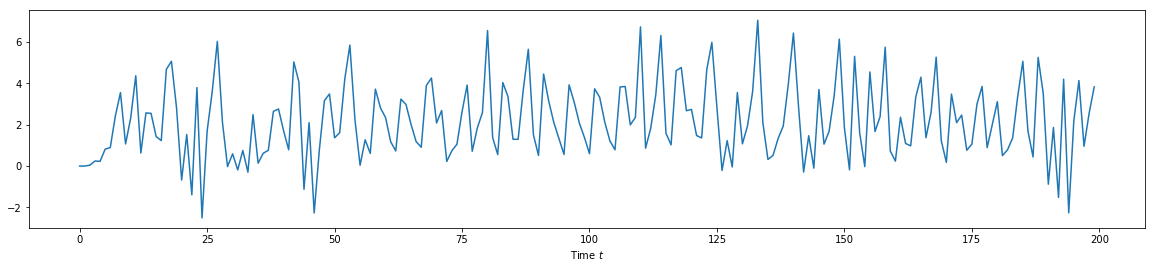

In [40]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Time $t$')
ax.plot(data[:200])
None

We plot Autocorrelation and Partial Autocorrelation:

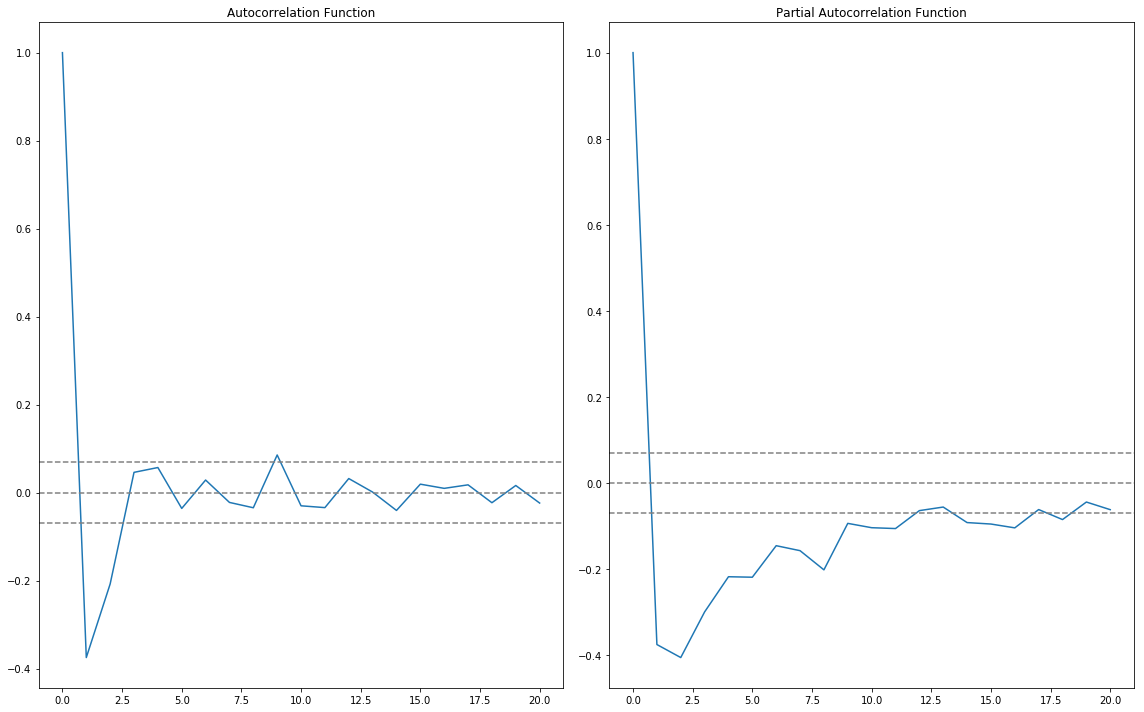

In [41]:
ts_diff = data['x'].values - data.shift(1)['x'].values
ts_diff = ts_diff[1:]
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
#Plot ACF: 
ax[0].plot(lag_acf)
ax[0].axhline(y=0,linestyle='--',color='gray')
ax[0].axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[0].axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[0].set_title('Autocorrelation Function')
#Plot PACF:
ax[1].plot(lag_pacf)
ax[1].axhline(y=0,linestyle='--',color='gray')
ax[1].axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[1].axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[1].set_title('Partial Autocorrelation Function')
fig.tight_layout()

Bassed on the above we choose $(p, q) = (4, 4)$ for our $\text{ARMA}(p, q)$-model. Also a higher values the inversion of the hassian-matrix fails.

In [42]:
arma = statsmodels.tsa.arima_model.ARMA(data['x'].values, order = (4, 4)).fit()

We plot the estimated values and residuals:

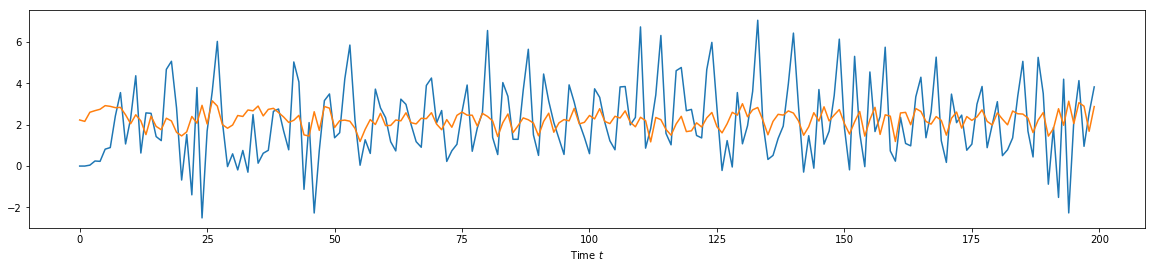

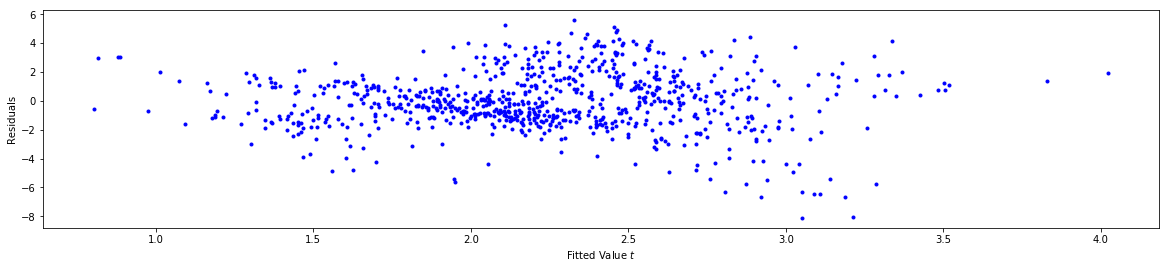

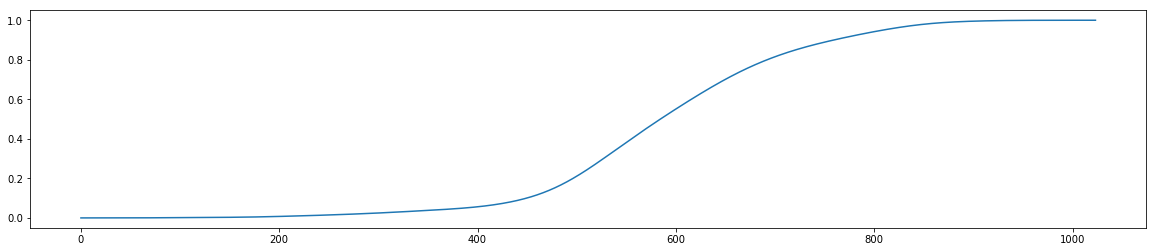

In [43]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Time $t$')
ax.plot(data[:200])
ax.plot(arma.fittedvalues[:200])

resid = data['x'].values - arma.fittedvalues
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Fitted Value $t$')
ax.set_ylabel(r'Residuals')
ax.plot(arma.fittedvalues, resid, color = 'b', marker = '.', linestyle='')

fig, ax = plt.subplots(figsize = (20, 4))
dens = sm.nonparametric.KDEUnivariate(resid)
dens.fit()
ax.plot(dens.cdf)

None

We are now "reasonably satisfied" and compute the LDF of the residuals:

I was not able to find any implementations of LDF in Python, so we will save the residuals an continue in R:

In [44]:
pd.DataFrame(resid, columns = ['resid']).to_csv('DataPart5_resid.csv', index = False)

See next page for R version.